# Práctica 2. Aprendizaje por refuerzo
## Inteligencia Artificial I    2022/2023

Grupo 22: 

  - Alejandro Barrachina Argudo
  - Walid Bousnitra Bousnitra


## Parte 1. Taxi
Vamos a utilizar como primer ejemplo un entorno de jugete de la librería Gym 

https://www.gymlibrary.dev/environments/toy_text/taxi/

Tenemos una rejilla rectangular con 4 ubicaciones (etiquetadas con letras diferentes) y nuestro trabajo es recoger al pasajero en una ubicación y dejarlo en otra. Se trata de llevar al pasajero que inicialmente está en Y (0,4) a la posición destino R (0,0). El taxi solo puede coger y dejar pasajeros en las posiciones marcadas.
Recibimos +20 puntos por dejar al pasajero con éxito y perderemos 1 punto por cada paso. También hay una penalización de 10 puntos por acciones ilegales de recoger y dejar.

En la librería OpenAI's Gym tenemos definido el modelo de este entorno de pruebas (Taxi) y podemos desarrollar y evaluar nuestro agente que aprende usando RL. La librería gym nos proporciona la representación y la visualización (render) del tablero por lo que no tenemos que hacerlo (aunque sería sencillo representarlo en AIMA y resolverlo con cualquiera de sus algoritmos de búsqueda). 

In [1]:
# Para el ejemplo del taxi y el cart pool es necesario instalar algunas librerías (gym,cmake,scipy) si no están ya instaladas
# !pip install cmake
# La librería gym proporciona problemas de prueba — environments — con una interfaz general que puedes usar para probar 
# distintos algoritmos y configuraciones de RL. 

# !pip install gym
#!pip install ale-python-interface
#!pip install gym --force-reinstall --user
# tps://gym.openai.com/docs/

##!pip install scipy
# import sys 
# !{sys.executable} -m pip install cmake
# import sys 
# !{sys.executable} -m pip install scipy
# import sys 
# !{sys.executable} -m pip install gym
# import sys 
# !{sys.executable} -m pip install gym[toy_text]
# import sys 
# !{sys.executable} -m pip install gym[all]

In [2]:
import numpy as np
import random
import gym
env = gym.make("Taxi-v3").env
# Taxi environment con la visualización por defecto
#env = gym.make('Taxi-v3',render_mode="human")
#env = gym.make('Taxi-v3',render_mode="rgb_array")
#env = gym.make('Taxi-v3',render_mode="ansi")
#env.render() 
# El render explícito da error en la ultima version de gym. 
# Hay que especificar el modo de render al hacer make y se hace automático. 

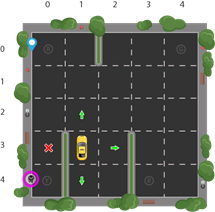

La interfaz principal del entorno gym es env. 
Vamos a utilizar los siguientes métodos de env:

- env.reset: restablece el entorno y devuelve un estado inicial aleatorio.

- env.step (acción): realiza un paso en el entorno. Devuelve:

      observación: estado siguiente del entorno al aplicar la acción
      recompensa: asociada a la acción en ese estado
      done: Indica fin del episodio por éxito (hemos recogido y dejado a un pasajero)
      info: información adicional como rendimiento y latencia para depuración
      
- env.render: renderiza el entorno (útil para visualizar el entorno)

In [3]:
# creamos e inicializamos el entorno 
env = gym.make('Taxi-v3',render_mode="human")
observation=env.reset()
# ejecuto una acción aleatoria
action = env.action_space.sample()
env.step(action)

(308,
 -10,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})

In [4]:
# Al ejecutar este fragmento de código veremos 20 episodios del tablero del taxi. 
# En cada episodio se prueban 10 acciones aleatorias.
env = gym.make('Taxi-v3',render_mode="human")
for i_episode in range(20):
    observation = env.reset() #devuelve  un estado inicial aleatorio.
    for t in range(10):
        #print("estado {}".format(observation))
        action = env.action_space.sample()  # acción aleatoria.
        #print("action {}".format(action))
        observation, reward, done, info, X = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break       
    print("Episodio terminado sin éxito")
env.close()

Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito


In [7]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


El Action Space tiene tamaño 6 y el State Space tiene tamaño 500. El algoritmo RL no necesita más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de forma única asignando un número único a cada estado posible, y RL aprende a elegir un número de acción de 0 a 5 donde:
   - 0 = sur
   - 1 = norte
   - 2 = este
   - 3 = oeste
   - 4 = recoger
   - 5 = dejar

Los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación de destino.

El aprendizaje por refuerzo aprenderá un mapeo de estados con la acción óptima a realizar en ese estado. Para ello realizaremos un proceso de exploración, es decir, el agente explora el entorno y toma acciones basadas en las recompensas definidas en el entorno. La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulativa a largo plazo según la fórmula vista para el Q-learning.

Dado el estado representado en la imagen anterior, vamos a codificar su estado y dárselo al entorno para que se renderice en Gym. 
Las filas y columnas se numeran de 0 a 4 y, como se ve en la imagen, tenemos el taxi en la fila 3, columna 1, nuestro pasajero está en la ubicación 2 y nuestro destino es la ubicación 0:  R (0), G (1), Y (2), B (3)

Usando el método de codificación de estado Taxi-v3, podemos hacer lo siguiente:

In [8]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state

State: 328


In [9]:
# La función print_frames la usaremos para visualizar los estados en modo texto.
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.2)

In [10]:
env = gym.make('Taxi-v3',render_mode="ansi")
env.reset()
env.s=state
action = env.action_space.sample()
state, reward, done, info, x = env.step(action)
frame = [] 
frame.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        })


In [11]:
# En este caso solo mostramos un estado
print_frames(frame)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 1
State: 427
Action: 0
Reward: -1


Podemos asertar las posiciones en el estado con env.encode() o usar los números entre 0 y 499 que son los 500 estados válidos en el espacio de estados. 

En la visualización anterior:
- El cuadrado representa el taxi, que es amarillo sin pasajero y verde con pasajero.
- La marca ("|") representa una pared que el taxi no puede cruzar.
- R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros y la letra morada es el destino actual.

In [12]:
env.s = 499
action = env.action_space.sample()
state, reward, done, info, x = env.step(action)
frame = [] 
frame.append({
        'frame': env.render(),
        'state': env.s,
        'action': action,
        'reward': reward
        })
print_frames(frame)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 1
State: 499
Action: 1
Reward: -1


In [13]:
# Hay una tabla (diccionario) P del entorno 
# Es equivalente a la matriz R que hemos visto en clase, pero tiene más informacion.
#podemos ver los valores de reward asignados por defecto al estado 328 que usamos como ejemplo
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la siguiente estructura {acción: [(probabilidad, próximo estado, recompensa, hecho)]}.

- El valor de 0-5 corresponde a las acciones (sur, norte, este, oeste, recogida, entrega) que el taxi puede realizar.
- La probabilidad es siempre 1.0 (en este entorno)
- nextstate muestra el estado siguiente usando la acción en este índice del diccionario.
- Las acciones de movimiento tienen por defecto una recompensa de -1 y pickup / dropoff tiene -10 Si estuvimos en un estado donde el taxi tiene un pasajero y estamos en la posición destino correcta se vería una recompensa de 20 en la action dropoff (5 ))
- done se utiliza para indicarnos cuándo hemos dejado a un pasajero en el lugar correcto. Cada dejada de un pasajero (dropoff) con éxito es el final de un episodio.

Hay que tener en cuenta que si nuestro agente eligiera explorar la acción dos (2) en este estado, iría hacia el este y chocaría contra una pared. El código fuente ha hecho imposible mover el taxi a través de una pared, por lo que si el taxi elige esa acción, seguirá acumulando -1 penalizaciones, lo que afecta la recompensa a largo plazo.

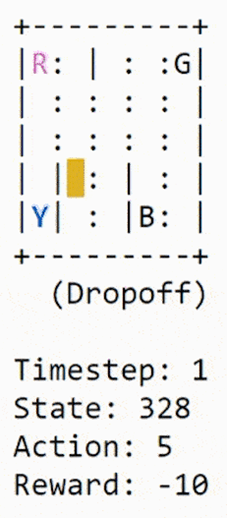

### Paso 1. Resolvemos el problema sin aprendizaje por refuerzo

Una vez que hemos entendido el modelo del entorno, veamos qué pasaría si intentamos utilizar la fuerza bruta para resolver el problema sin RL.
Dado que tenemos nuestra tabla P para las recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo con eso.
Crearemos un bucle infinito que se ejecutará hasta que un pasajero llegue a un destino (un episodio), o en otras palabras, cuando la recompensa recibida sea 20.

El método env.action_space.sample () selecciona automáticamente una acción aleatoria del conjunto de todas las acciones posibles.


In [14]:
action = env.action_space.sample()
action

3

In [15]:
env = gym.make('Taxi-v3',render_mode="ansi")
#env.s = 328  # podemos fijar un estado inicial (por ejemplo el estado 328) o un estado aleatorio con reset
env.reset()

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info, x = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timesteps taken: 772
Penalties incurred: 238


In [16]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 772
State: 0
Action: 5
Reward: 20


El agente va a ciegas y utiliza miles de pasos de tiempo y realiza muchos drop-offs incorrectos para entregar un solo pasajero al destino correcto (cuando acierta de casualidad).  

Os dejo como ejercicio opcional la resolución de este problema con cualquiera de los algoritmos de búsqueda de AIMA. Simplemente hay que definir la clase Problem haciendo llamadas a env. 
Usando la codificación numérica de los estados de este entorno y las 5 acciones que hemos visto haciendo una llamada a next_state, reward, done, info = env.step(action) 

Vamos a resolverlo aquí con Aprendizaje por refuerzo que empieza haciendo ciclos a ciegas y aprende de la experiencia pasada.  Cuando "por casualidad" acertamos el agente guarda en la memoria (en forma de recompensa) qué acción fue la mejor para cada estado. Así en el futuro elegirá esa acción. 

In [17]:
import gym
env = gym.make("Taxi-v3").env
# Estado inicial aleatorio
env.reset() # reset environment to a new, random state   EStado inicial aleatorio 
# O estado inicial establecido 
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state

State: 328


In [18]:
state = env.encode(3, 1, 2, 0)     # 3,1 son as coordenadas del taxi.  
# 2 y 0 son las posiciones del pasajero y dejada del pasajero que estan numeradas de 0..4
#  passenger index, destination index  (creo que para indicar que esta en el taxi se usa tambien .. mirar.)

action = env.action_space.sample()    # genera una acción aleatoria
# Recordamos las acciones: 0 = south; 1 = north; 2 = east; 3 = west; 4 = pickup; 5 = dropoff
next_state, reward, done, info, X = env.step(action) 
print("State:", state)
print("Action:", action)

State: 328
Action: 2


In [19]:
#next_state = env.step(action)[0] 
print("Next State:", next_state)
env.s = next_state

Next State: 441


In [20]:
action = 5   
# Recordamos las acciones: 0 = south; 1 = north; 2 = east; 3 = west; 4 = pickup; 5 = dropoff
next_state, reward, done, info, X = env.step(action) 
print("State:", state)
print("Next Action:", action)

State: 328
Next Action: 5


In [21]:
print("Next State:", next_state)
env.s = next_state

# como hacemos dropoff de un taxi vacio no hace nada

Next State: 441


In [22]:
env.s = 300
state = env.s
next_state = 0
action = 3   
next_state, reward, done, info,X = env.step(action) 
print("State:", state)
print("Next Action:", action)
print("Next State:", next_state)

State: 300
Next Action: 3
Next State: 421


### Aprendizaje por refuerzo

Vamos a utilizar el algoritmo de Q-learning que hemos visto en clase y que le dará a nuestro agente algo de memoria.
Básicamente, Q-learning permite al agente utilizar las recompensas del entorno para aprender, con el tiempo, la mejor acción a realizar en un estado determinado.
En nuestro entorno de Taxi, tenemos la tabla de recompensas, P, de la que el agente aprenderá. Lo hace buscando recibir una recompensa por realizar una acción en el estado actual y luego actualizar un valor Q para recordar si esa acción fue beneficiosa.
Los valores almacenados en la tabla Q se denominan valores Q y se asignan a una combinación (estado, acción).
Un valor Q para una combinación de acción de estado particular es representativo de la "calidad" de una acción tomada desde ese estado. Mejores valores Q implican mejores posibilidades de obtener mayores recompensas.
Por ejemplo, si el taxi se enfrenta a un estado que incluye a un pasajero en su ubicación actual, es muy probable que el valor Q para la recogida sea más alto en comparación con otras acciones, como la bajada o el norte.
Los valores Q se inicializan a un valor arbitrario y, a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los valores Q se actualizan mediante la ecuación:

Q (estado, acción) ← (1 − α) Q (estado, acción) + α (recompensa + γ maxa Q (siguiente estado, todas las acciones))

Dónde:
- α (alfa) es la tasa de aprendizaje (0 <α≤1) 
     - Al igual que en los entornos de aprendizaje supervisado, αα es la medida en que nuestros valores Q se actualizan en cada iteración.
- γ (gamma) es el factor de descuento (0≤γ≤1) 
    - Determina cuánta importancia queremos dar a las recompensas futuras. Un valor alto para el factor de descuento (cercano a 1) captura la recompensa efectiva a largo plazo, mientras que un factor de descuento de 0 hace que nuestro agente considere solo la recompensa inmediata.

En la fórmula anterior estamos asignando (←), o actualizando, el valor Q del estado actual y la acción del agente tomando primero un peso (1 − α) del antiguo valor Q y luego agregando el valor aprendido. El valor aprendido es una combinación de la recompensa por realizar la acción actual en el estado actual y la recompensa máxima descontada del siguiente estado en el que estaremos una vez que realicemos la acción actual.
Básicamente, estamos aprendiendo la acción adecuada a tomar en el estado actual al observar la recompensa por la combinación estado / acción actual y las recompensas máximas para el siguiente estado. Esto eventualmente hará que nuestro taxi considere la ruta con las mejores recompensas.
El valor Q de un par estado-acción es la suma de la recompensa instantánea y la recompensa futura descontada (del estado resultante). La forma en que almacenamos los valores Q para cada estado y acción es a través de una tabla Q

La tabla Q es una matriz donde tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0 y luego los valores se actualizan después del entrenamiento. Tenga en cuenta que la Q-table tiene las mismas dimensiones que la mesa de recompensas, pero tiene un propósito completamente diferente.

En la siguiente figura los valores de la Q-Table se inicializan a cero y se van actualizando durante el aprendizaje.  Los valores optimizan el recorrido del agente a traves del entorno buscando las máximas recompensas. 

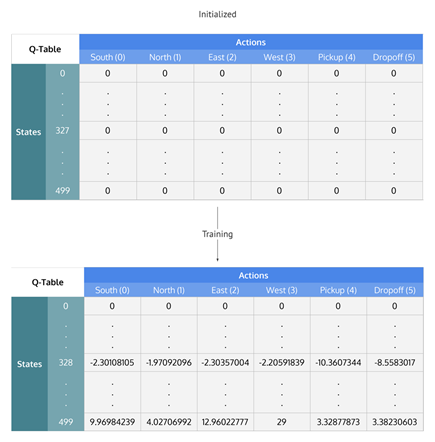

### Resumen del proceso de Q-Learning

    • Inicializar la tabla Q a todo ceros.
    • Comenzar a explorar acciones: para cada estado, seleccione cualquiera de las posibles acciones para el estado actual (S).
    • Ir al siguiente estado (S ') como resultado de esa acción (a).
    • Para todas las acciones posibles del estado (S '), seleccione la que tenga el valor Q más alto.
    • Actualizar los valores de la tabla Q utilizando la ecuación.
    • Establecer el siguiente estado como el estado actual.
    • Si se alcanza el estado objetivo, finalizar y repetir el proceso.

### Explotación de valores aprendidos

Después de una fase de exploración aleatoria de acciones, los valores Q tienden a converger sirviendo a nuestro agente como una función de valor de acción que puede explotar para elegir la acción mejor para un estado dado.
Existe una compensación entre exploración (elegir una acción aleatoria) y explotación (elegir acciones basadas en valores Q ya aprendidos). Queremos evitar que la acción siga siempre la misma ruta y posiblemente se sobreajuste, por lo que introduciremos otro parámetro llamado ϵ "épsilon" para atender esto durante el entrenamiento.
En lugar de simplemente seleccionar la acción de valor Q mejor aprendida, a veces preferimos explorar más el espacio de acción. Un valor de épsilon más bajo da como resultado episodios con más penalizaciones (en promedio), lo cual es obvio porque estamos explorando y tomando decisiones al azar.

In [23]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ejecutar el aprendizaje es un proceso lento pero se realiza una única vez. 
Una vez entrenado, podemos resolver cualquier problema de este entorno simplemente consultando la tabla y eligiendo la acción que maximiza la recompensa en cada paso (explotación). 
El algoritmo de entrenamiento que actualizará esta Q-table a medida que el agente explora el entorno durante miles de episodios. 

En la primera parte del bucle (while not done) decidimos si elegir una acción aleatoria o explotar los valores Q ya calculados. Esto se hace simplemente usando el valor épsilon y comparándolo con la función random.uniform (0, 1), que devuelve un número arbitrario entre 0 y 1.
Ejecutamos la acción elegida en el entorno para obtener el next_state y la recompensa por realizar la acción. Después de eso, calculamos el valor Q máximo para las acciones correspondientes al next_state, y con eso, podemos actualizar fácilmente nuestro valor Q al new_q_value:

In [24]:
env.reset()
state = env.s
state

300

Episode: 100000
Training finished.



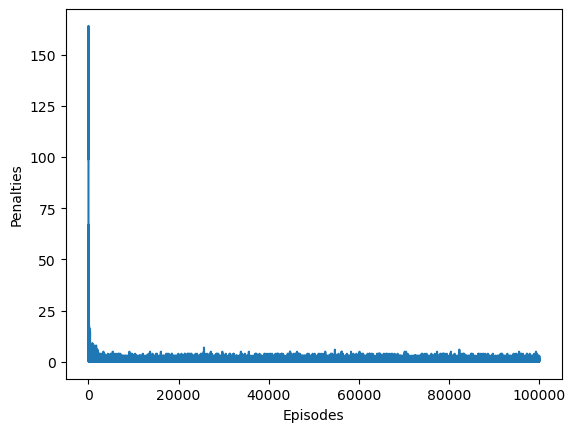

In [25]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
"""Training the agent"""

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    env.reset()
    state = env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, X = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    all_epochs.append(i)
    all_penalties.append(penalties)
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

# Plotting things

plt.plot(all_epochs, all_penalties)
plt.xlabel("Episodes")
plt.ylabel("Penalties")
plt.show()


In [23]:
# La tabla Q ha cambiado despues de 100000 episodios. Vamos a ver cuales son los Q-values aprendidos en el estado de ejemplo. 
q_table[328]

array([ -2.40350573,  -2.27325184,  -2.40608639,  -2.35906512,
       -10.75429306, -10.91729211])

Observa el valor máximo de Q en el estado 328. ¿Te parece que Q-learning ha aprendido efectivamente la mejor acción a realizar en este estado?

### Evaluar el comportamiento del agente despues del proceso de Q-learning 

Para evaluar el comportamiento de nuestro agente no necesitamos explorar más acciones. En el comportamiento del agente ahora la siguiente acción siempre se selecciona utilizando el mejor valor Q:

In [24]:
total_epochs, total_penalties = 0, 0
episodes = 100
env = gym.make("Taxi-v3").env

for _ in range(episodes):
    env.reset()
    state = env.s
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 12.94
Average penalties per episode: 0.0


Podemos ver en la evaluación que el comportamiento del agente ha mejorado significativamente y no hay penalizaciones, lo que significa que realizó las acciones correctas de recogida / devolución con 100 pasajeros diferentes.

Comparando los dos agentes vemos como aunque con Q-learning el agente comete errores inicialmente durante la exploración, una vez que ha explorado lo suficiente (visto la mayoría de los estados), puede actuar sabiamente maximizando las recompensas haciendo movimientos inteligentes. 

Veamos cuánto mejor es nuestra solución de Q-learning en comparación con el agente que realiza movimientos aleatorios.

Evaluamos a nuestros agentes de acuerdo con las siguientes métricas,

    • Número medio de penalizaciones por episodio: Cuanto menor sea el número, mejor será el desempeño de nuestro agente. Idealmente, nos gustaría que esta métrica fuera cero o muy cercana a cero.

    • Número promedio de pasos de tiempo por viaje: también queremos un número pequeño de pasos de tiempo por episodio, ya que queremos que nuestro agente dé pasos mínimos (es decir, el camino más corto) para llegar al destino.

    • Promedio de recompensas por movimiento: cuanto mayor sea la recompensa, significa que el agente está haciendo lo correcto. Es por eso que decidir las recompensas es una parte crucial del aprendizaje por refuerzo. En nuestro caso, dado que tanto los tiempos como las penalizaciones se recompensan negativamente, una recompensa promedio más alta significaría que el agente llega al destino lo más rápido posible con la menor cantidad de penalizaciones.


    Average rewards per move	-3.9012092102214075	0.6962843295638126
    Average number of penalties per episode	920.45	0.0
    Average number of timesteps per trip	2848.14	12.38

Estas métricas se calcularon en más de 100 episodios. 
Y como muestran los resultados, nuestro agente de Q-learning tiene un buen comportamiento. 


### Hiperparámetros y optimizaciones

Los valores de `alpha`,` gamma` y `epsilon` que hemos utilizado han sido elegidos por intuición, prueba y error pero hay mejores formas de obtener buenos valores. Idealmente, los tres deberían disminuir con el tiempo porque a medida que el agente continúa aprendiendo, en realidad construye antecedentes más válidos y duraderos;

    • α: (la tasa de aprendizaje) debería disminuir a medida que continúa adquiriendo una base de conocimientos cada vez mayor.
    • γ: a medida que se acerca cada vez más al valor límite, su preferencia por la recompensa a corto plazo debería aumentar, ya que no estará el tiempo suficiente para obtener la recompensa a largo plazo, lo que significa que su gamma debería disminuir.
    • ϵ: a medida que desarrollamos nuestra estrategia, tenemos menos necesidad de exploración y más explotación para obtener más utilidad de nuestra política, por lo que en vez de utilizar un valor fijo, a medida que aumentan los ensayos, épsilon debería disminuir. Al principio un épsilon alto genera más episodios de exploración y al final un épsilon bajo explota el conocimiento aprendido.

Una forma de obtener la combinación correcta de valores de hiperparámetros sería usar optimización local con algoritmos genéticos (que veremos en el próximo tema). 

Q-learning es uno de los algoritmos de aprendizaje por refuerzo más fáciles. Sin embargo, el problema con la obtención de Q es que, una vez que el número de estados en el entorno es muy alto, se vuelve difícil implementarlos con la tabla Q, ya que el tamaño sería muy, muy grande. Por eso se utilizan redes neuronales profundas en lugar de Q-table (Deep Reinforcement Learning). La red neuronal recibe información de estado y acciones en la capa de entrada y aprende a generar la acción correcta a lo largo del tiempo. Las técnicas de aprendizaje profundo (como las redes neuronales convolucionales) también se utilizan para interpretar los píxeles en la pantalla y extraer información del juego (como puntuaciones), y luego dejar que el agente controle el juego.

### Ejercicios   

#### Ejercicio 1.

En el problema del Taxi resuelto con Q-Learning se pide experimentar de forma sistemática con distintos estados iniciales, distintos valores de los hiperparámetros y con distinto números de episodios de aprendizaje y comentar los resultados obtenidos. 
Observa explícitamente el comportamiento del agente con los valores límite de los hiperparámetros. 
Comenta de forma razonada las conclusiones obtenidas de los distintos procesos de aprendizaje. 
Evalua y compara los agentes respecto a las métricas dadas.

Viendo la gráfica del anterior entrenamiento, podemos ver que el sistema aprende muy rápido en este puzle concreto, así que lo primero a probar será reducir el número de episodios de entrenamiento

In [25]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
"""Training the agent"""

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 50001):
    env.reset()
    state = env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info, X = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * \
            (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    all_epochs.append(i)
    all_penalties.append(penalties)
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")



Episode: 50000
Training finished.



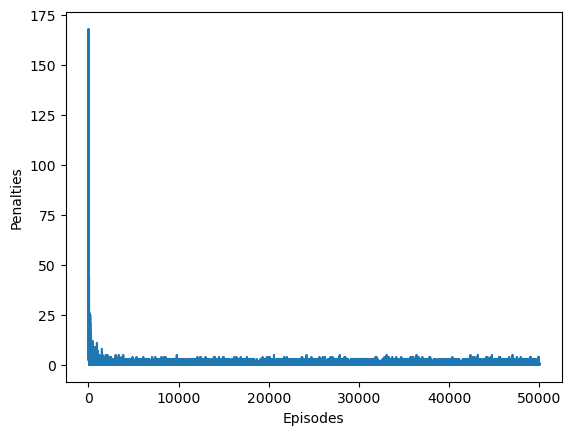

In [26]:
# Plotting things

plt.plot(all_epochs, all_penalties)
plt.xlabel("Episodes")
plt.ylabel("Penalties")
plt.show()


In [27]:
total_epochs, total_penalties = 0, 0
episodes = 100
env = gym.make("Taxi-v3").env

for i in range(episodes):
    env.reset()
    state = env.s
    epochs, penalties, reward = 0, 0, 0

    done = False
    while not done:
        
        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 13.09
Average penalties per episode: 0.0


El número de episodios se ha reducido a la mitad y aún así conseguimos una puntuación similar. Con estos hiperparámetros no podemos reducir mucho más el número de episodios ya que el algoritmo empieza a fallar

Para la siguiente prueba reduciremos el número de episodios pero cambiaremos los hiperparámetros para ver que resultados obtenemos

In [28]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
"""Training the agent"""

# Hyperparameters
episodes_test = 5001
alpha = 0.9
gamma = 0.3
epsilon = 1
epsilon_decay = 1/(episodes_test - 1)

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, episodes_test):
    env.reset()
    state = env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info, X = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * \
            (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    epsilon -= epsilon_decay

    all_epochs.append(i)
    all_penalties.append(penalties)
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 5000
Training finished.



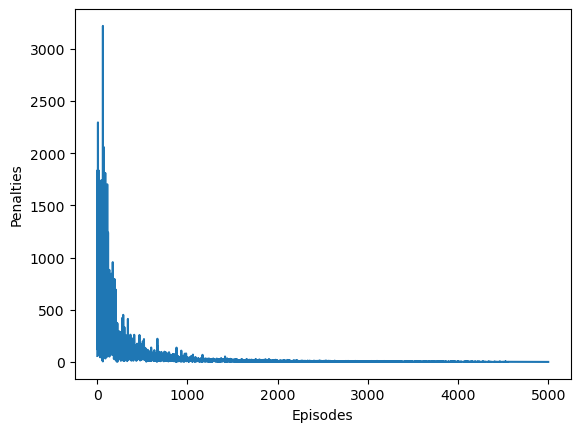

In [29]:
# Plotting things

plt.plot(all_epochs, all_penalties)
plt.xlabel("Episodes")
plt.ylabel("Penalties")
plt.show()


In [30]:
total_epochs, total_penalties = 0, 0
episodes = 100
env = gym.make("Taxi-v3").env

for i in range(episodes):
    env.reset()
    state = env.s
    epochs, penalties, reward = 0, 0, 0

    done = False
    while not done:

        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 12.87
Average penalties per episode: 0.0


Con 5000 episodios ahora podemos conseguir un aprendizage consistente al variar el epislon en el tiempo para que cada vez explote más los conocimientos conseguidos.

Probaremos ahora a variar los parametros alpha y gamma para ver si conseguimos mejorar los resultados de tiempo

In [31]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
"""Training the agent"""

# Hyperparameters
episodes_test = 30001
alpha = 0.9
gamma = 0.8
epsilon = 1
epsilon_decay = 1/(episodes_test - 1)

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, episodes_test):
    env.reset()
    state = env.s
    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info, X = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * \
            (reward + gamma * next_max)
        q_table[state, action] = new_value
        # gamma = np.maximum(1, gamma + 0.000001)
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    alpha -= 0.000002
    epsilon -= epsilon_decay

    all_epochs.append(i)
    all_penalties.append(penalties)
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 30000
Training finished.



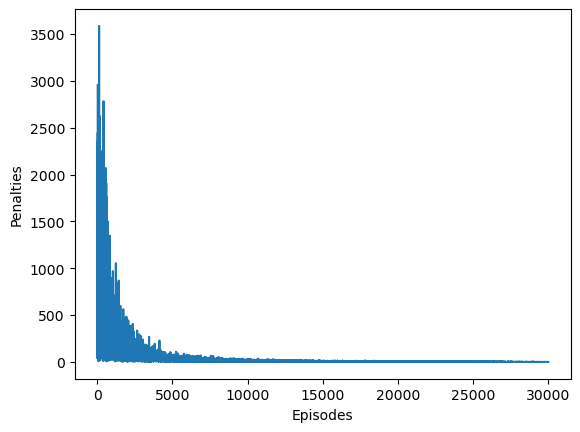

In [32]:
# Plotting things

plt.plot(all_epochs, all_penalties)
plt.xlabel("Episodes")
plt.ylabel("Penalties")
plt.show()


In [33]:
total_epochs, total_penalties = 0, 0
episodes = 100
env = gym.make("Taxi-v3").env

for i in range(episodes):
    env.reset()
    state = env.s
    epochs, penalties, reward = 0, 0, 0

    done = False
    while not done:

        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 13.17
Average penalties per episode: 0.0


Al ser un problema pequeño no se aprecia un cambio en los timesteps medios al resolver los estados aún cambiando los hiperparámetros

#### Ejercicio 2. Opcional
Resuelve el problema del taxi con cualquiera de los algoritmos de búsqueda de AIMA. Para ello tendrás que definir una subclase de Problem en la que los estados utilicen la codificación numérica de los 500 estados del entorno env de Gym con las 6 acciones.
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

En el código de la clase Problem tendrás que hacer uso de las funciones de env, por ejemplo, result corresponde a una llamada a:  env.next_state, reward, done, info, X = env.step(action)

In [34]:
from search import Problem, breadth_first_tree_search

class Taxi(Problem):
    def __init__(self, initial, goal=None):
        self.done = False
        super().__init__(initial, self.goal_test)
        
    def actions(self, state):
        acs = []
        for action in range(0, self.initial.action_space.n):
            next_state, reward, self.done, info, X = self.initial.step(action)
            if (next_state != self.initial.s):
                acs.append(action)
        return acs
    
    def result(self,estado,accion):
        self.next_state, reward, self.donde, info, X = self.initial.step(action)
        return self.next_state

    def goal_test(self, state):
        return self.done

In [35]:
%%time
env.reset()
initial = env

t = Taxi(initial=initial)

breadth_first_tree_search(t)

t.initial.s

CPU times: user 620 µs, sys: 63 µs, total: 683 µs
Wall time: 591 µs


333

### Parte 2. Uso de entrenamiento con QLearning para otro entorno de Gym

Realizar el mismo proceso de entrenamiento con QLearning para otro entorno de OpenAI Gym


In [36]:
## pip install gym[all] 
## para instalar gym con todas sus dependencias

# CartPole

Aunque se incluye para comentarlo en clase, este dominio no lo vamos a resolver porque utiliza valores continuos y no es posible entrenarlo con QLearning que usa valores discretos. 

https://gym.openai.com/envs/CartPole-v1/  

Un poste está unido por una articulación no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanece en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical o el carro se mueve más de 2.4 unidades desde el centro.

In [37]:
# Generamos el entorno CartPole v1 y realizamos acciones aleatorias. 
# Se trata de maximizar el tiempo que el palo está en equilibrio.

env = gym.make("CartPole-v1", render_mode="human")
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info, X = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break            
env.close()

Episode finished after 14 timesteps
Episode finished after 16 timesteps
Episode finished after 18 timesteps
Episode finished after 28 timesteps
Episode finished after 19 timesteps
Episode finished after 27 timesteps
Episode finished after 17 timesteps
Episode finished after 20 timesteps
Episode finished after 24 timesteps
Episode finished after 19 timesteps
Episode finished after 26 timesteps
Episode finished after 15 timesteps
Episode finished after 43 timesteps
Episode finished after 23 timesteps
Episode finished after 30 timesteps
Episode finished after 21 timesteps
Episode finished after 38 timesteps
Episode finished after 13 timesteps
Episode finished after 29 timesteps
Episode finished after 11 timesteps


#### Ejercicio 3. 
Se pide realizar un agente que aprenda a resolver alguno de los problemas toy_text incluidos en Gym (con representación discreta) usando Q-Learning: https://www.gymlibrary.dev/environments/toy_text/
Comenta el resultado obtenido y realiza pruebas (como en el ejercicio 2) para comprobar el comportamiento con distintos valores de los hiperparámetros. 
Es sencillo el entorno FrozenLake-v0  https://gym.openai.com/envs/FrozenLake-v0/ 
En este entorno el agente controla el movimiento de un personaje en un mundo de rejilla. Algunas baldosas son transitables (walkable) y otras hacen que el agente caiga al agua. La dirección de movimiento del agente es incierta y solo depende parcialmente de la dirección elegida (porque puede resbalar en el hielo). La recompensa se obtiene cuando el agente llega a traves de un camino transitable a una casilla objetivo. 

In [38]:
env = gym.make('FrozenLake-v1', render_mode="ansi")
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,X  = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 5 timesteps
Episode finished after 7 timesteps
Episode finished after 4 timesteps
Episode finished after 7 timesteps
Episode finished after 4 timesteps
Episode finished after 3 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 16 timesteps
Episode finished after 2 timesteps
Episode finished after 7 timesteps
Episode finished after 14 timesteps
Episode finished after 4 timesteps
Episode finished after 13 timesteps
Episode finished after 9 timesteps
Episode finished after 3 timesteps
Episode finished after 4 timesteps
Episode finished after 13 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps


In [39]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
"""Training the agent"""

# Hyperparameters
episodes_test = 100001
alpha = 0.55
gamma = 0.85
epsilon = 1
epsilon_decay = 0.001

# For plotting metrics
all_epochs = []
all_success = []

for i in range(1, episodes_test):
    env.reset()
    state = env.s
    done = False
    all_success.append("Failure")
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info, X = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * \
            (reward + gamma * next_max)
        q_table[state, action] = new_value
        # gamma = np.maximum(1, gamma + 0.000001)
        if reward:
          all_success[-1] = "Success"

        state = next_state
        epochs += 1
    # alpha -= 0.000002
    epsilon = np.maximum(0, epsilon - epsilon_decay)

    all_epochs.append(i)
    # all_penalties.append(penalties)
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 100000
Training finished.



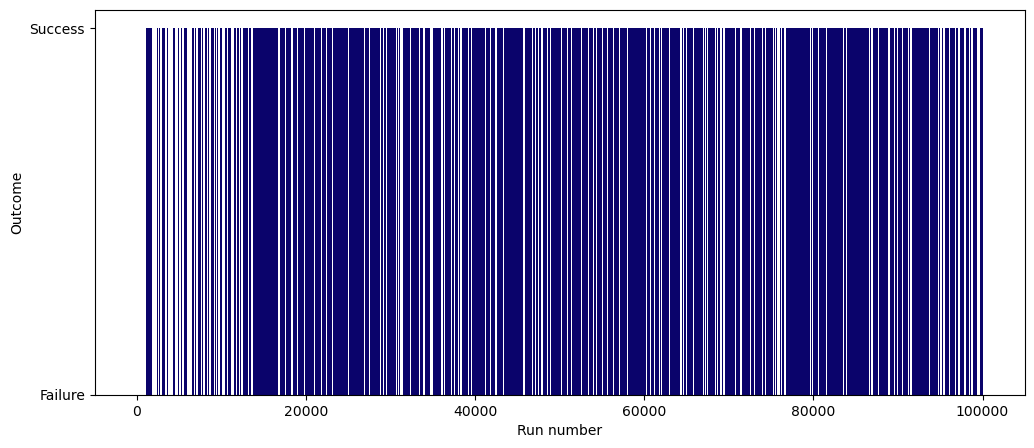

In [40]:
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
plt.bar(all_epochs, all_success, color="#0A036B", width=1.0)
plt.show()


In [41]:
total_success = 0
episodes = 100
env = gym.make('FrozenLake-v1', render_mode="ansi").env

for i in range(episodes):
    env.reset()
    env.render()
    state = env.s
    epochs, penalties, reward = 0, 0, 0

    done = False
    while not done:

        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward:
            total_success += 1
    env.close()

print(f"Results after {episodes} episodes:")
print(f"Winrate: {(total_success / episodes) * 100}%")


Results after 100 episodes:
Winrate: 75.0%


#### Ejercicio 4.  Opcional.   
Aplica el algoritmo Q-learning para diseñar un agente que aprenda a resolver alguno de los puzles que tienes resueltos en la práctica 1 (puzle de 8, jarras, misioneros,..). 
Comenta el resultado comparandolo con el comportamiento del agente que ya tienes hecho de la práctica anterior que resuelve el problema usando búsqueda en espacio de estados.  
Discute claramente las ventajas e inconvenientes con las métricas y resultados obtenidos.

Si no resuelves el problema puedes hacer el razonamiento teórico de cómo se comportaría el agente con Q-learning si lo comparamos con un agente que resuelve el problema con búsqueda en el espacio de estados. Indica las ventajas e inconvenientes de las dos aproximaciones. 

In [42]:
class Ocho_Puzzle(Problem):
    """Problema a del 8-puzzle.  Los estados serán tuplas de nueve elementos,
    permutaciones de los números del 0 al 8 (el 0 es el hueco). Representan la
    disposición de las fichas en el tablero, leídas por filas de arriba a
    abajo, y dentro de cada fila, de izquierda a derecha. Las cuatro
    acciones del problema las representaremos mediante las cadenas:
    "Mover hueco arriba", "Mover hueco abajo", "Mover hueco izquierda" y
    "Mover hueco derecha", respectivamente."""""

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        """ Define goal state and initialize a problem """
        self.goal = goal
        Problem.__init__(self, initial, goal)

    def state(self, estado):
        mhd = 0
        goal = (1, 2, 3, 4, 5, 6, 7, 8, 0)
        for i in range(len(estado)):
            if (estado.index(i) != goal.index(i)):
                mhd += int((abs(i - goal.index(estado[i]))/3) +
                           ((abs(i-goal.index(estado[i])))) % 3)
                # / 3 para saber la distancia vertical
                # % 3 para saber la distancia horizontal

        return mhd

    def actions(self, estado):
        pos_hueco = estado.index(0)  # busco la posicion del 0
        accs = list()
        if pos_hueco not in (0, 1, 2):
            accs.append(1)
        # COMPLETA LA DEFINICIÓN DE LOS OPERADORES.
        if pos_hueco not in (6, 7, 8):
            accs.append(2)
        if pos_hueco not in (0, 3, 6):
            accs.append(3)
        if pos_hueco not in (2, 5, 8):
            accs.append(4)

        if len(accs) == 0:
            return 0
        pos = random.randint(0, len(accs) - 1)
        return accs[pos]

    def result(self, estado, accion):
        pos_hueco = estado.index(0)
        l = list(estado)
        if accion == 1:
            l[pos_hueco] = l[pos_hueco-3]
            l[pos_hueco-3] = 0
        # COMPLETA LA DEFINICIÓN DE LOS OPERADORES.
        elif accion == 2:
            l[pos_hueco] = l[pos_hueco+3]
            l[pos_hueco+3] = 0
        elif accion == 4:
            l[pos_hueco] = l[pos_hueco+1]
            l[pos_hueco+1] = 0
        elif accion == 3:
            l[pos_hueco] = l[pos_hueco-1]
            l[pos_hueco-1] = 0

        return tuple(l)

    def h(self, node):
        """ Return the heuristic value for a given state. """
        return 1

    def check_solvability(self, state):
        """ Checks if the given state is solvable """
        # The solvability of a configuration can be checked by calculating the Inversion Permutation.
        # If the total Inversion Permutation is even then the initial configuration is solvable else the initial configuration is not solvable which means that only 9!/2 initial states lead to a solution.
        inversion = 0
        for i in range(len(state)):
            for j in range(i+1, len(state)):
                if (state[i] > state[j]) and state[i] != 0 and state[j] != 0:
                    inversion += 1
        return inversion % 2 == 0


In [43]:
def genRandom8Puzle():
    options = [0,1,2,3,4,5,6,7,8]
    res = []

    for i in range(0,9):
        pos = random.randint(0,len(options) - 1)
        res.append(options[pos])
        del options[pos]
    return tuple(res)

for i in range(0,5): 
    s = Ocho_Puzzle(genRandom8Puzle())
    print(s.initial, s.state(estado=s.initial), sep=" ", end='\n')

(1, 5, 8, 3, 4, 2, 6, 0, 7) 11
(1, 2, 6, 7, 8, 3, 4, 5, 0) 5
(2, 1, 6, 0, 7, 5, 8, 3, 4) 16
(8, 1, 3, 7, 4, 6, 5, 0, 2) 9
(3, 4, 7, 0, 6, 5, 8, 2, 1) 18


In [ ]:

from IPython.display import clear_output
import random
from math import factorial
import matplotlib.pyplot as plt
import numpy as np
q_table = np.zeros([factorial(9), 5])
"""Training the agent"""

# Hyperparameters
episodes_test = 100001
alpha = 0.55
gamma = 0.85
epsilon = 1
epsilon_decay = 0.001

# For plotting metrics

all_epochs = []

for i in range(1, episodes_test):
    env = Ocho_Puzzle(initial=genRandom8Puzle())
    while(not env.check_solvability(env.initial)):
        env = Ocho_Puzzle(initial=genRandom8Puzle())
    done = False
    state = env.initial
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.actions(state)  # Explore action space
            if action == 0:
                pass
        else:
            action = np.argmax(q_table[env.state(state)])  # Exploit learned values

        try:
            next_state = env.result(state, action)
        except:
            pass

        old_value = q_table[env.state(state), action]
        next_max = np.max(q_table[env.state(next_state)])

        new_value = (1 - alpha) * old_value + alpha * \
            (reward + gamma * next_max)
        q_table[env.state(state), action] = new_value
        # gamma = np.maximum(1, gamma + 0.000001)
        if env.goal_test(state):
            done = True

        state = next_state
        epochs += 1
    # alpha -= 0.000002
    epsilon = np.maximum(0, epsilon - epsilon_decay)

    all_epochs.append(i)
    # all_penalties.append(penalties)
    # if i % 100 == 0:
    clear_output(wait=True)
    print(f"Episode: {i}")

print("Training finished.\n")


In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 100

for i in range(episodes):
    env = Ocho_Puzzle(initial=genRandom8Puzle())
    while (not env.check_solvability(env.initial)):
        env = Ocho_Puzzle(initial=genRandom8Puzle())
    epochs = 0

    done = False
    while not done:

        action = np.argmax(q_table[env.state(state)])
        state = env.result(state, action)

        if env.goal_test():
            done = True

        epochs += 1
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Esta es una prueba de concepto en la que utilizariamos algún mecanismo para codificar cada estado del 8 puzle y así darle información a la tabla Q. En este caso utilizamos la distancia manhatan solo como un representante y no como un modelo final de codificación de estados.

